# Neural Cellular Automata for Lightweight, Robust and Explainable Classification of White Blood Cell Images

* Paper Code : 5588
* Paper Link : https://papers.miccai.org/miccai-2024/559-Paper3422.html
* Reproduction Level : 3 (25 points)
* Github Link : https://github.com/prachuryanath/WBC-NCA---Reproduction

**Paper abstract** : The paper presents a Neural Cellular Automata (NCA)-based approach for white blood cell classification in peripheral blood smears, addressing key challenges in deep learning: generalizability, domain shifts, and explainability.

The suggested approach achieves competitive performance on three datasets while being lightweight and requiring fewer parameters. The NCA framework, in contrast to conventional models, is naturally interpretable and resilient to domain shifts, offering insights into its decision-making process. Because of these benefits, it is a viable substitute for clinical settings, improving hematological diagnosis's precision and openness. Beyond traditional deep learning techniques, the study emphasizes NCA's promise in medical imaging.

### By - Prachurya Nath
<div>
<img src="https://raw.githubusercontent.com/marrlab/WBC-NCA/29b4a5eee16f5a80d05cf03d2b5046420d8aba93/src/images/model_graphic.svg" width="750" />
</div>

## Hardware
* Graphics Used : A100 (40 GB)
* Training Time : 5 hrs 1 mins

<div>
<img src="https://raw.githubusercontent.com/prachuryanath/WBC-NCA---Reproduction/refs/heads/main/images/Screenshot_20250218_162208.png" width="350" />
</div>

## Table to Reproduce
* I trained on Matek-19 and tested on Matek-19 as the other datasets were not publicly available or the link to the datasets were broken. 
* The primary goal was to reproduce the results as closely as possible, and reaching the 92% accuracy benchmark indicates that the model's performance was consistent with the original findings.

<div>
<img src="https://github.com/prachuryanath/WBC-NCA---Reproduction/blob/main/images/Screenshot_20250218_164414_Drive.jpg?raw=true" width="500" />
</div>

## Create environment and install libraries
(Use Cuda supported GPUs)
* python3 -m venv .wbc
* source wbc/bin/activate
* pip install -r requirements.txt

## Import libraries

In [2]:
#IMPORTS
import yaml
import csv
import kagglehub
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import zennit.composites as z
from zennit.attribution import Gradient
from torchvision.transforms import v2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import src.utils.utils as utils
import src.datasets.Dataset as Dataset 
from src.models.NCA import MaxNCA, ConvNCA, SimpleNCA
from src.losses.LossFunctions import BCELoss
from src.agents.Agent import Agent

/home/hpc/mrrr/mrrr101v/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model configuration

In [3]:
config_path = "config.yaml"
with open(config_path) as file:
  config = yaml.safe_load(file)
config

{'train_set': 'AML',
 'name': 'train',
 'balance': True,
 'resize': 64,
 'batch_size': 16,
 'fold': 2,
 'model': 'MaxNCA',
 'channel_n': 128,
 'hidden_size': 128,
 'steps': 64,
 'learning_rate': 0.0004,
 'n_epochs': 30}

## Steps to download dataset and then rename to Matek-19

In [ ]:
# Download latest version
path = kagglehub.dataset_download("binilj04/aml-cytomorphology")

print("Path to dataset files:", path)

In [4]:
# Configuration of experiment
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataloading
AML_data_path = "datasets/Matek-19/"

## Data Preparation and Loader Initialization for AML Classification

In [5]:
# # Load and Prepare AML Data
X_AML,y_AML = utils.get_data_AML(AML_data_path,show_distribution=False)
X_AML=np.asarray(X_AML)
y_AML=np.asarray(y_AML)

# Initialize Stratified K-Fold Cross-Validation
fold=config["fold"]
skf_AML = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf_AML.get_n_splits(X_AML, y_AML)

# Split Data into Training and Testing Sets
for i,(train_index, test_index) in enumerate(skf_AML.split(X_AML, y_AML)):
    if i != fold:
        continue
    X_AML_train, X_AML_test = X_AML[train_index], X_AML[test_index]
    y_AML_train, y_AML_test = y_AML[train_index], y_AML[test_index]

In [6]:
# Create AML Training and Validation Datasets
AML_train_dataset = Dataset.WBC_Dataset(X_AML_train,y_AML_train, augment=True, resize=config["resize"],dataset="AML")
AML_val_dataset = Dataset.WBC_Dataset(X_AML_test,y_AML_test, resize=config["resize"],dataset="AML")

/home/hpc/mrrr/mrrr101v/.local/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
# Configure Sampling Strategy for Class Imbalance
if config["balance"]:
    AML_sampler = data.WeightedRandomSampler(weights=utils.get_weights(y_AML_train), num_samples=len(AML_train_dataset), replacement=True)
else:
    sampler=None

# Initialize Data Loaders for Training and Validation
AML_train_loader = data.DataLoader(AML_train_dataset,sampler=AML_sampler,batch_size=config["batch_size"])
AML_val_loader = data.DataLoader(AML_val_dataset, batch_size=1)

## Model Initialization

In [8]:
# Select and Initialize NCA Model
if config["model"]=="MaxNCA":
    model=MaxNCA(channel_n=config["channel_n"], hidden_size=config["hidden_size"])
elif config["model"]=="ConvNCA":
    model=ConvNCA(channel_n=config["channel_n"], hidden_size=config["hidden_size"])
else:
    model=SimpleNCA(channel_n=config["channel_n"], hidden_size=config["hidden_size"])

In [ ]:
# Train the model on the selected dataset
if config["train_set"]=="AML":
    agent.train(AML_train_loader,AML_val_loader,BCELoss,config["n_epochs"],config["name"]+"AML")
    # Evaluate model performance and visualize confusion matrix
    utils.get_confusion_matrix(model,agent,AML_val_loader,config["name"]+"_"+config["train_set"]+"_AML",config["steps"])

# Save the trained model
torch.save(model.state_dict(), "models/"+config["name"]+"_trained_on_"+config["train_set"])

In [9]:
# Initialize Agent for Model Training
model.to(device)
agent=Agent(model,config["steps"],config["channel_n"],config["batch_size"])

## Model evaluation

In [ ]:
# RESULTS AND VISUALIZATION
utils.get_confusion_matrix(model,agent,AML_val_loader,config["name"]+"_"+config["train_set"]+"_AML",config["steps"])

<div>
<img src="https://github.com/prachuryanath/WBC-NCA---Reproduction/blob/main/images/loss-curve.png?raw=true" width="450" />
</div>


In [10]:
# Save model and evaluate on test set
model.load_state_dict(torch.load("models/train_trained_on_AML"))
model.eval()

MaxNCA(
  (p0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, padding_mode=reflect)
  (p1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, padding_mode=reflect)
  (fc0): Linear(in_features=384, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=128, bias=False)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=13, bias=True)
)

In [12]:
# Test accuracy function
def compute_test_accuracy(model, agent, test_loader, device):
    r"""Computes the test accuracy of the trained model on the validation dataset.
        # Args:
            model: Trained neural cellular automata (NCA) model.
            agent: Agent handling data preparation and inference.
            test_loader: DataLoader containing test samples.
            device: CUDA or CPU device.
        # Returns:
            float: Accuracy of the model on the test set.
    """
    correct = 0 # Initialize correct predictions counter
    total = 0 # Initialize total sample counter

    with torch.no_grad():  # Disabling gradient computation for evaluation
        for inputs, targets in test_loader:
            inputs, targets = agent.prepare_data((inputs, targets))
            outputs, _, _ = agent.get_outputs((inputs, targets))

            predictions = torch.sigmoid(outputs)
            predicted_labels = torch.argmax(predictions, dim=1)
            true_labels = torch.argmax(targets, dim=1)

            correct += (predicted_labels == true_labels).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    # Save accuracy to CSV file for analysis
    with open("test_accuracy.csv", mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Test Set", "Accuracy (%)"])
        writer.writerow(["AML", f"{accuracy * 100:.2f}"])
    return accuracy

## Results (Reproduced from the table)

* After training and testing the model, I achieved the same level of test accuracy as reported in the table, which was 92.5%.

In [13]:
# Compute test accuracy
test_accuracy = compute_test_accuracy(model, agent, AML_val_loader, device)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

Final Test Accuracy: 92.40%


## Explainability of the model

Along with testing the model, the following parts also explain how it makes decisions by highlighting which parts of the input were most important for its predictions. This helps understand why the model gives certain results and ensures it is making reliable decisions.

In [14]:
# Class definition for the NCA_max model
class NCA_max(nn.Module):
    def __init__(self, channel_n=16, fire_rate=0.5, device="cpu", hidden_size=128, input_channels=3, init_method="standard"):
        super(NCA_max, self).__init__()
        # Setting device to GPU if available, otherwise CPU
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # Number of channels and input channels
        self.channel_n = channel_n
        self.input_channels = input_channels
        # Perception layers: Depthwise convolution with padding to maintain spatial dimensions
        self.p0 = nn.Conv2d(channel_n, channel_n, kernel_size=3, stride=1, padding=1, groups = channel_n, padding_mode="reflect")
        self.p1 = nn.Conv2d(channel_n, channel_n, kernel_size=3, stride=1, padding=1, groups = channel_n, padding_mode="reflect")
        # Fully connected layers for state update
        self.fc0 = nn.Linear(channel_n*3, hidden_size)
        self.fc1 = nn.Linear(hidden_size, channel_n, bias=False)
        # Stochastic update parameter
        self.fire_rate = fire_rate
        self.to(self.device)

    # Perception function to gather neighborhood information
    def perceive(self, x):
        z1 = self.p0(x)
        z2 = self.p1(x)
        y = torch.cat((x,z1,z2),1)
        return y

    # State update function with stochastic gating
    def update(self, x_in, fire_rate):
        x = x_in.transpose(1,3)
        dx = self.perceive(x)
        dx = dx.transpose(1,3)
        dx = self.fc0(dx)
        dx = F.relu(dx)
        dx = self.fc1(dx)

        # Apply stochastic gating
        if fire_rate is None:
            fire_rate=self.fire_rate
        stochastic = torch.rand([dx.size(0),dx.size(1),dx.size(2),1])>fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic

        # Update state
        x = x+dx.transpose(1,3)
        x = x.transpose(1,3)
        return x
    
    # Forward pass through the model
    def forward(self, x, steps=32, fire_rate=0.5):
        for step in range(steps):
            x2 = self.update(x, fire_rate).clone()
            x = torch.concat((x[...,:self.input_channels], x2[...,self.input_channels:]), 3)
        
        # Apply adaptive max pooling to reduce spatial dimensions
        max=F.adaptive_max_pool2d(x.permute(0, 3, 1, 2), (1, 1))
        out = max.view(max.size(0), -1)
        return out#,x

# Class definition for the Classifier
class Classifier(nn.Module):
    def __init__(self,channel_n=16):
        super(Classifier, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.channel_n=channel_n
        self.fc2 = nn.Linear(channel_n,128)
        self.fc3 = nn.Linear(128,13)
        self.to(self.device)

    # Forward pass through the classifier
    def forward(self, x):
        out = self.fc2(x)
        out = F.relu(out)
        out =self.fc3(out)
        return out#,x

In [15]:
# Initialize and load the NCA model
channels=128
model=MaxNCA(channels,128)
agent=Agent(model,64,channels,1)
model.load_state_dict(torch.load("models/train_trained_on_AML",map_location=torch.device('cpu')))
model.eval()
model1=NCA_max(channels,128)
model2=Classifier(channels)

# Initialize modified NCA model and classifier
original_state_dict = model.state_dict()
model1_dict = model1.state_dict()
model2_dict = model2.state_dict()

# Transfer learning: Load relevant layers into the new models
model1_dict.update({k: v for k, v in original_state_dict.items() if 'p0' in k or 'p1' in k or 'fc0' in k or 'fc1' in k})
model2_dict.update({k: v for k, v in original_state_dict.items() if 'fc2' in k or 'fc3' in k})

# Load the modified state_dict into the new model
model1.load_state_dict(model1_dict)
model2.load_state_dict(model2_dict)
#%%

<All keys matched successfully>

In [16]:
# Path to the test images
imgs_path=["test_samples/EBO_0001.tiff",
                "test_samples/EOS_0001.tiff",
                "test_samples/KSC_0001.tiff",
                "test_samples/LYA_0001.tiff",
                "test_samples/LYT_0001.tiff",
                "test_samples/MMZ_0001.tiff",
                "test_samples/MOB_0001.tiff",
                "test_samples/MON_0001.tiff",
                "test_samples/MYB_0001.tiff",
                "test_samples/MYO_0001.tiff",
                "test_samples/NGB_0001.tiff",
                "test_samples/NGS_0001.tiff",
                "test_samples/PMO_0001.tiff",
                "test_samples/BAS_0001.tiff"]

# Function to load and preprocess test samples
def get_sample(i=1,imgs_path=[]):
    imgs_path=imgs_path

    norm = v2.Compose([v2.ToTensor(), v2.Normalize(mean=[0.82069695, 0.7281261, 0.836143],std=[0.16157213, 0.2490039, 0.09052657])])
    img = Image.open(imgs_path[i])
    img = img.resize((64,64))
    img=np.array(img)[:,:,0:3]
    img = norm(img).permute(1,2,0)
    return img[None,:,:,:]

/home/hpc/mrrr/mrrr101v/.local/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


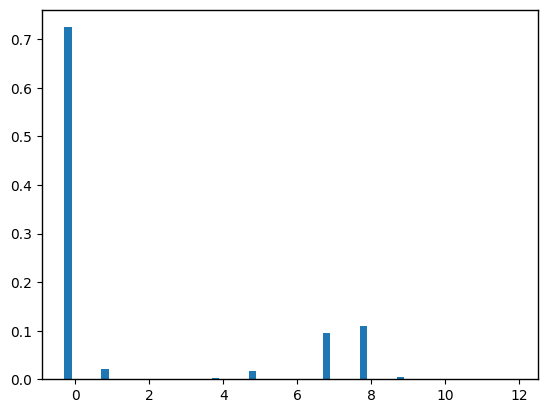

In [ ]:
# Gradient-based relevance attribution using Zennit
composite = z.EpsilonPlus()
img=get_sample(13,imgs_path=imgs_path).to('cuda:0')
x=agent.make_seed(img)
input = model1(x)
max=[]
min=[]

# Compute relevance and visualize feature importance
with Gradient(model2, composite) as attributor:
    output, relevance = attributor(input, torch.eye(13)[[4]].to('cuda:0'))
mpl.rcParams['axes.linewidth'] = 1
size=0.2
X_axis = np.arange(13) 
plt.bar(X_axis -size,F.sigmoid(output[0]).detach().cpu().numpy(),size)
relevance=(relevance-relevance.min())/(relevance.max()-relevance.min())
relevance=2*relevance-1

relevance=relevance.cpu().numpy()

### Visualization of feature maps

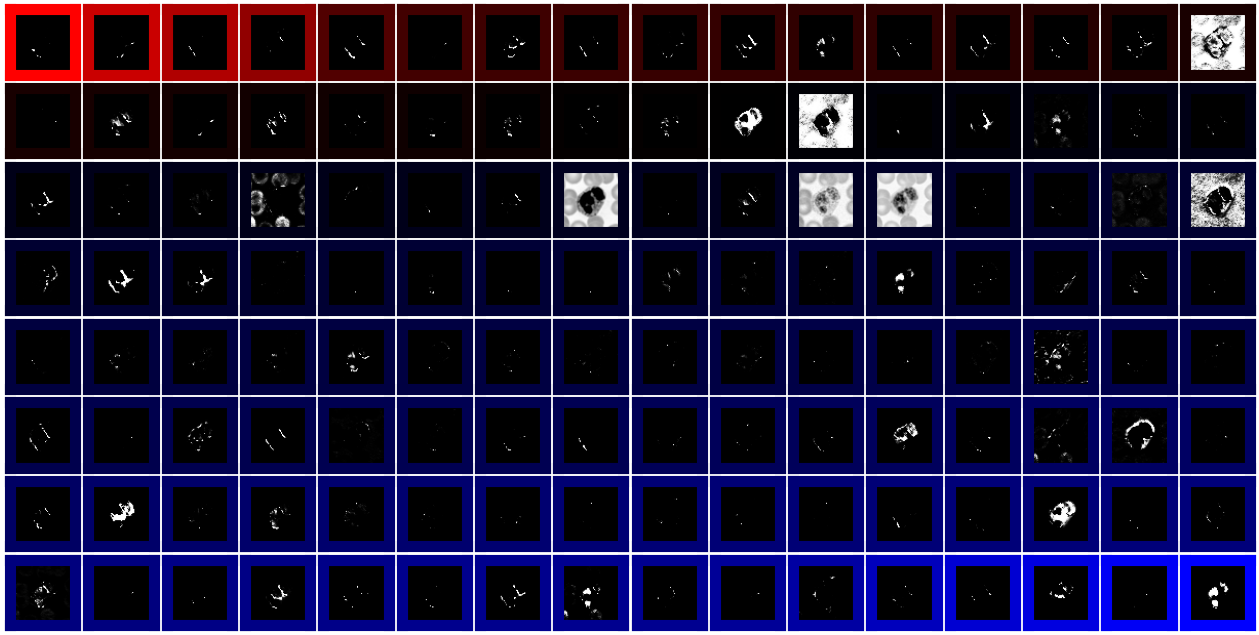

In [18]:
mpl.rcParams['axes.linewidth'] = 8
sample=img

idx=np.argsort(relevance[0])
idx=np.flip(idx)
rel=[relevance[0,i] for i in idx]

height=8
width=16

# Visualization of feature maps with relevance scores
plt.figure("visualise", (width,height))
out,feat_map=model(agent.make_seed(sample), steps=64,fire_rate=0.5)
feature_map=feat_map.detach()
sig=torch.nn.Sigmoid()
feature_map_sig=sig(feature_map-5) #sigmoid is applied for visualization, changing this function controls how much of the feature is visible in the plot
feature_map=torch.cat((feature_map[:,:,:,:3],feature_map_sig[:,:,:,3:]),axis=3).cpu()
for i in range(height):
    for j in range(width):
        channel=width*i+j
        ax= plt.subplot(height,width,channel+1)
        r=relevance[0,idx[channel]]
        if r>0:
            ax.spines['bottom'].set_color((r,0,0))
            ax.spines['top'].set_color((r,0,0))
            ax.spines['left'].set_color((r,0,0))
            ax.spines['right'].set_color((r,0,0))
        else:
            ax.spines['bottom'].set_color((0,0,-r))
            ax.spines['top'].set_color((0,0,-r))
            ax.spines['left'].set_color((0,0,-r))
            ax.spines['right'].set_color((0,0,-r))
        plt.xticks([])
        plt.yticks([])
        plt.gray()
        plt.imshow(feature_map[0,:,:,idx[channel]])

### Plot of highest relevance channels for 4 example images

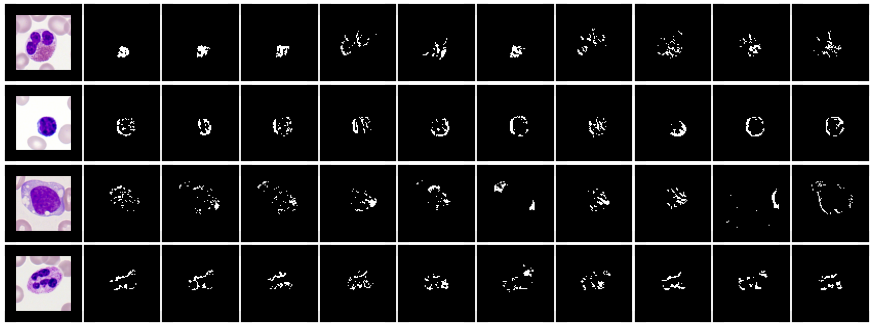

In [19]:
# Define the grid dimensions for visualizing the images and feature maps
height=4
width=11
plt.figure("visualise", (width,height))

# Define the sample indices to be visualized
samples=[1,3,6,11]
preds=[1,9,7,4]

# Loop through each sample for visualization
for i in range(height):
    img=get_sample(samples[i],imgs_path=imgs_path)
    x=agent.make_seed(img)
    input = model1(x)
    with Gradient(model2, composite) as attributor:
        output, relevance = attributor(input, torch.eye(13)[[preds[i]]].to('cuda:0'))
    relevance=(relevance-relevance.min())/(relevance.max()-relevance.min())
    relevance=2*relevance-1
    relevance=relevance.cpu().numpy()
    
    # Get the feature maps from the model for the current sample
    sample=img
    idx=np.argsort(relevance[0])
    idx=np.flip(idx)
    rel=[relevance[0,i] for i in idx]
    
    # Forward pass to get the feature maps
    out,feat_map=model(agent.make_seed(sample), steps=64,fire_rate=0.5)
    feature_map=feat_map.detach()
    sig=torch.nn.Sigmoid()
    agg_mask=torch.zeros([64,64])
    
    # Loop through the grid columns for visualization
    for j in range(width):
        channel=width*i+j
        ax= plt.subplot(height,width,channel+1)
        r=relevance[0,idx[channel]]
        plt.xticks([])
        plt.yticks([])
        plt.gray()
        if j ==0:
            plt.imshow(Image.open(imgs_path[samples[i]]))
        else:
            map=feature_map[0,:,:,idx[j-1]].cpu()
            mask=map>torch.quantile(map,0.98)
            plt.imshow(mask)
    
    # Save the final visualization as an SVG file
    plt.savefig("final_results.svg")

## Challenges

* **Dataset Unavailability:** The paper was tested on three datasets, but only Matek-19 was accessible from the internet. This limited my evaluation of model's generalizability to domain shifts in different areas.

* **Unstructured Folder Organization:** The repository had disorganized structure which made it difficult to find relevant scripts. I had to restructure the directory which needed to also make configuration files and made a single notebook to train.

* **Lack of Comments and Headings:** The code lacked comments mostly and section headings, making it challenging to understand the workflow. I added detailed comments and organized the code into logical sections to improve readability for future users.

## Conclusion

The reproduction of the WBC-NCA paper is rated as Level 3 because it required quite a few adjustments. Since the other datasets were unavailable, Matek-19 was the only one used for training and testing, which limited the ability to assess the model's generalisability. The repository itself was quite disorganized, so I had to restructure the directory and write new configuration files to make it more manageable. The lack of comments and clear section headings in the code made it hard to follow the workflow, so I added thorough comments and reorganized the code. These changes were necessary to ensure the results matched the original paper.